# CSS688 Term Project Option 3
# Twitter Stocker
## Author: Mike Zhong
## Using the Twitter API to implement sentiment analysis on different sets of stocks
## https://github.com/myz540/twitter_stocker

## Setup

* Create a twitter account (out of scope) and through the developer section, get a set of `OAuth` credentials
* `import` dependencies (see `requirements.txt` for specific version numbers)
* The `requirements.txt` file has a LONG list of requirements, this is a result of my using an anaconda distribution and using `pip freeze > requirements.txt` which inevitably captured all the packages bundled with the distribution
* `import twitter_utils`, my custom library containing classes to handle the work

## 1) Import the necessary libraries 

In [1]:
# comes with python 3.6
import datetime
import re
import configparser

In [2]:
# additional libraries
import tweepy
from tweepy import OAuthHandler
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
# This is my custom module and contains classes which implement all the heavy lifting. It merits a good read and implements a
# (hopefully) easy-to-use interface for developers to build off of.
from twitter_utils import *

In [4]:
config = configparser.ConfigParser()

In [5]:
config.read('config/keys.txt')

['config/keys.txt']

## 2) Authenticate User: you should use ideally use your own login credentials

In [6]:
consumer_key = config['DEFAULT']['consumer_key']
consumer_secret = config['DEFAULT']['consumer_secret']
access_token = config['DEFAULT']['access_token']
access_secret = config['DEFAULT']['access_secret']

In [7]:
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

# plug into the matrix
api = tweepy.API(auth)
api

## 3) Load the pre-populated list of NASDAQ companies
This csv file was downloaded from the internet via a simple Google search

In [8]:
ticker_df = pd.read_csv('files/companylist.csv')

In [9]:
ticker_df.head()

,Symbol,Name,LastSale,MarketCap,IPOyear,Sector,industry,Summary Quote,Unnamed: 8
0,YI,"111, Inc.",6.5100,$530.85M,2018.0,Health Care,Medical/Nursing Services,https://www.nasdaq.com/symbol/yi,NaN
1,PIH,"1347 Property Insurance Holdings, Inc.",5.2899,$31.81M,2014.0,Finance,Property-Casualty Insurers,https://www.nasdaq.com/symbol/pih,NaN
2,PIHPP,"1347 Property Insurance Holdings, Inc.",24.5000,$17.15M,NaN,Finance,Property-Casualty Insurers,https://www.nasdaq.com/symbol/pihpp,NaN
3,TURN,180 Degree Capital Corp.,1.8600,$57.89M,NaN,Finance,Finance/Investors Services,https://www.nasdaq.com/symbol/turn,NaN
4,FLWS,"1-800 FLOWERS.COM, Inc.",18.3400,$1.18B,1999.0,Consumer Services,Other Specialty Stores,https://www.nasdaq.com/symbol/flws,NaN


In [10]:
ticker_df.shape

(3428, 9)

## 4) Determine the Gainers and Losers for a given day
The `StockHandler` object from `twitter_utils` is a custom object implemented to find the gainers and losers from a given day. The object wraps the `pandas_datareader` and makes calls to the `iex` financial database in order to get stock price information. The `StockHandler` also implements methods for computing the gain/loss or `diff`, as well as finding the three winning and losing stocks for a given day.

There are several matters to address here:

1) How do we define a gain or a loss?

* A gain or loss will be calculated as price(close)- price(open) / price(open)

2) What day should we use when finding the gainers and losers?

* technically, any day can be passed to the StockHandler method for collecting tweets, I will use the yesterday

3) How can we ensure the tweets fetched are relevant to the given day?

* To ensure the tweets fetched were tweeted before the day in question, the implementing methods will check the timestamp
of the tweet to ensure it is before the day in question. The tweets are returned in order of "most recent" so we are sure 
to capture relevant tweets

To accomplish this, we create a dictionary with the company's ticker as the key and the `diff` as the value, where the `diff` is computed as stated above

In [11]:
tickers = ticker_df['Symbol'].drop_duplicates()
print(tickers.head())
print(len(tickers))

0       YI
1      PIH
2    PIHPP
3     TURN
4     FLWS
Name: Symbol, dtype: object
3428


In [12]:
# the date of the lookup will default to yesterday
# this step is lengthy since the pandas_datareader is limited in the number of queries it can make per unit time
# if you need to save time swap the limit by uncommenting/commenting

limit = 100
#limit = len(tickers)
diff_dict = StockHandler.get_all_diffs(tickers, limit=limit)

In [13]:
winner_dict, loser_dict = StockHandler.find_gainers_and_losers(diff_dict)
print(winner_dict)
print(loser_dict)

{'GNMX': 0.20399999999999996, 'AGFSW': 0.16749999999999993, 'AKTX': 0.04985337243401757, 'ADIL': 0.04382470119521926, 'AMCN': 0.03296703296703287, 'ADAP': 0.03225806451612891, 'AIRG': 0.030322580645161332, 'ADRO': 0.03022670025188908, 'ARPO': 0.01960784313725492, 'ABMD': 0.01611662576462413}
{'AMTX': -0.04285714285714277, 'ACAD': -0.04449741756058804, 'ARAY': -0.04827586206896551, 'ABEO': -0.05637254901960784, 'YI': -0.057803468208092484, 'ACOR': -0.06025179856115108, 'ADES': -0.06611570247933876, 'ACRS': -0.08029197080291968, 'AKRX': -0.08783783783783777, 'ADOM': -0.13053401609363574}


## 5) Instantiate a CorpusHandler and begin querying twitter
Now we know the companies we are interested in, we can start querying twitter. In my first pass, I created a search function to query just the ticker symbol, but found that I often could not find 100 tweets for small, irrelevant companies, which sometimes show up as winners or losers. To guard against this, I created an `extended_search` method which will also query the company name, and finally, the sector, if the symbol alone doesn't provide enough tweets

It is important to note that the search period for these tweets must be relevant to the when the gainers and losers were identified. The `expanded_search` and `collect_tweets` methods both default to yesterday

The `CorpusHandler` object from `twitter_utils` is a custom object that was implemented to handle much of the heavy lifting. This class contains a variety of methods for handling corpus as strings of tokens separated by whitespace or a delimiter of your choice, as well as converting the corpus into a list of tokens. This class also implements methods for saving and loading a corpora. The two attributes `gainer_corpus` and `loser_corpus` are populated when read from disk, these objects are also what get written to disk when saving. They are `dict` objects with the company as the key mapping to the 100 tweets stored as a `list` of strings. These strings will be pre-processed in section 6 before ultimately populating these two attributes

In [14]:
# create a CorpusHandler, custom object 
corpus_handler = CorpusHandler(api, ticker_df)

In [15]:
# we need 3 companies that can produce 100 tweets, we have 10 gainers and losers so that should be sufficient search space
# it's easy to overload the twitter API and go over the usage limit...
gainer_tweet_dict = dict()
good_tweets = 0

for symbol in winner_dict.keys():
    print(symbol)
    tweet_list = corpus_handler.expanded_search(symbol)
    
    if tweet_list and len(tweet_list) == 100:
        print(len(tweet_list))
        gainer_tweet_dict[symbol] = tweet_list 
        good_tweets += 1
        
    if good_tweets >= 3:
        break

GNMX
WARN: Less than 100 results, you should be using expanded_search()
WARN: Less than 100 results, you should be using expanded_search()
WARN: Less than 100 results, you should be using expanded_search()
AGFSW
WARN: Less than 100 results, you should be using expanded_search()
WARN: Less than 100 results, you should be using expanded_search()
WARN: Less than 100 results, you should be using expanded_search()
AKTX
WARN: Less than 100 results, you should be using expanded_search()
100
ADIL
WARN: Less than 100 results, you should be using expanded_search()
WARN: Less than 100 results, you should be using expanded_search()
WARN: Less than 100 results, you should be using expanded_search()
AMCN
WARN: Less than 100 results, you should be using expanded_search()
WARN: Less than 100 results, you should be using expanded_search()
WARN: Less than 100 results, you should be using expanded_search()
ADAP
WARN: Less than 100 results, you should be using expanded_search()
100
AIRG
WARN: Less than 10

In [16]:
loser_tweet_dict = dict()
good_tweets = 0

for symbol in loser_dict.keys():
    print(symbol)
    tweet_list = corpus_handler.expanded_search(symbol)
    
    if tweet_list and len(tweet_list) == 100:
        print(len(tweet_list))
        good_tweets += 1
        loser_tweet_dict[symbol] = tweet_list 
    
    if good_tweets >= 3:
        break

AMTX
WARN: Less than 100 results, you should be using expanded_search()
WARN: Less than 100 results, you should be using expanded_search()
100
ACAD
WARN: Less than 100 results, you should be using expanded_search()
100
ARAY
WARN: Less than 100 results, you should be using expanded_search()
100


## 6) Pre Process the tweets such that each tweet ends up as a clean string of tokens separated by whitespace.
1) Take the tweet, which is a `tweepy.api.Status` object and convert it to a `str` using our helper function

2) Use the `PreProcessor` object to clean and tokenize the string into a `list` of tokens

3) Convert the `list` of tokens back into a string of tokens separated by white space

4) Populate the gainer and loser corpus using the symbol as the key and the list of cleaned tweets as the value

In [17]:
# instantiate the PreProcessor
preprocessor = PreProcessor()

In [18]:
corpus_handler.gainer_corpus = dict()
corpus_handler.loser_corpus = dict()

print("Populating gainer_corpus")
for symbol, tweet_list in gainer_tweet_dict.items():
    corpus_handler.gainer_corpus[symbol] = list()
    for tweet in tweet_list:
        text = corpus_handler.get_corpus(tweet)
        cleaned_tokens = preprocessor.process_text_tweet(text)
        cleaned_text = corpus_handler.convert_list_to_corpus(cleaned_tokens)
        corpus_handler.gainer_corpus[symbol].append(cleaned_text)
    
print("Populating loser_corpus")
for symbol, tweet_list in loser_tweet_dict.items():
    corpus_handler.loser_corpus[symbol] = list()
    for tweet in tweet_list:
        text = corpus_handler.get_corpus(tweet)
        cleaned_tokens = preprocessor.process_text_tweet(text)
        cleaned_text = corpus_handler.convert_list_to_corpus(cleaned_tokens)
        corpus_handler.loser_corpus[symbol].append(cleaned_text)

Populating gainer_corpus
Populating loser_corpus


## 7) We can now find the most commonly used words in each corpus and visualize. We can also define a vocabulary using these words and subsequently create document-term matrices which we can write and read from disk as numpy objects
1) Use the `CorpusHandler.get_word_counts()` method to get the most commonly used words

2) Use `wordcloud.Wordcloud()` to assist with visualization. Wrapped by the `CorpusHandler.make_word_cloud()` method

3) We can save the corpora stored in the `CorpusHandler.gainer_corpus` and `CorpusHandler.loser_corpus` using the `save_corpus` method

4) we can load corpora into the `CorpusHandler.gainer_corpus` and `CorpusHandler.loser_corpus` using the `load_corpus` method

In [19]:
gainer_words = list()
loser_words = list()

for k,v in corpus_handler.gainer_corpus.items():
    gainer_words = [words.split() for words in v]
    gainer_words = [word for words in gainer_words for word in words]
    

for k,v in corpus_handler.loser_corpus.items():
    loser_words = [words.split() for words in v]
    loser_words = [word for words in loser_words for word in words]

In [20]:
print(len(gainer_words))
print(len(loser_words))

724
580


In [21]:
gainer_df = CorpusHandler.get_word_counts(gainer_words)
gainer_df.sort_values('frequency', ascending=False, inplace=True)
gainer_df.head(10)

724
      word  frequency
0  staying          1
1   groove          2
2      ali          1
3  program         94
4    朝mori         15


,word,frequency
3,program,94
67,music,21
68,patio,21
12,amp,19
133,musik,17
134,barista,17
66,fire,16
251,sparkle,15
252,sparkler,15
4,朝mori,15


In [22]:
loser_df = CorpusHandler.get_word_counts(loser_words)
loser_df.sort_values('frequency', ascending=False, inplace=True)
loser_df.head(10)

580
            word  frequency
0             rt         14
1            uhm          1
2           aray         80
3           http         33
4  czarinahjoyce          1


,word,frequency
2,aray,80
3,http,33
0,rt,14
89,wa,8
127,wah,5
128,thought,4
34,pass,4
158,back,4
233,know,3
25,pulpmx,3


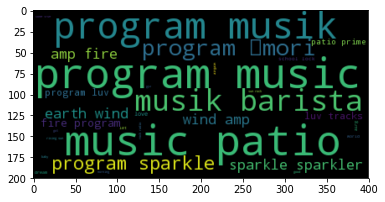

In [23]:
CorpusHandler.make_wordcloud(gainer_words)

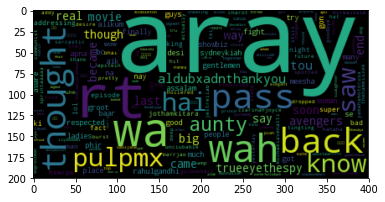

In [24]:
CorpusHandler.make_wordcloud(loser_words)

In [25]:
# save the corpora, my convention prefixes 'gainer.' and 'loser.' to the argument
# any crazy characters that can't be encoded will throw a `UnicodeEncodeError` and those tweets will be skipped
corpus_handler.save_corpus(filename='data.corpus')

In [26]:
# you can load the corpora using the command below, just uncomment

# corpus_hander.load_corpus(filename='data.corpus')

## 8) Vocabulary and Document-Term Matrix
1) Define a vocab using the 100 most commonly used words from each corpus
* much of this work is done in Section 7

2) Create dtms using this vocab for the two corpora
* We will use the `sklearn.feature_extraction.text.CountVectorizer()` object and can generate sparse matrices representing a dtm by instantiating the object with a vocab generated earlier, and then passing each corpus through it. Each row will end up being a tweet
* encode gainers as 0 and losers as 1

3) We can proceed to train a model with this dtm but that is beyond the scope of this assignment

In [27]:
gainer_most_common = gainer_df.loc[:, 'word'][:100].tolist()

In [28]:
loser_most_common = loser_df.loc[:, 'word'][:100].tolist()

In [29]:
total_common = set(gainer_most_common + loser_most_common)
len(total_common)

192

In [30]:
vectorizer = CountVectorizer(vocabulary=total_common)

In [31]:
all_gainer_tweets = [v for vs in corpus_handler.gainer_corpus.values() for v in vs]
all_loser_tweets = [v for vs in corpus_handler.loser_corpus.values() for v in vs]
print(len(all_gainer_tweets))
print(len(all_loser_tweets))

300
300


In [32]:
all_tweets = all_gainer_tweets + all_loser_tweets
all_y = [0]*300 + [1]*300
len(all_tweets), len(all_y)

(600, 600)

In [33]:
vectorizer.fit_transform(all_tweets, all_y)

<600x192 sparse matrix of type '<class 'numpy.int64'>'
	with 1483 stored elements in Compressed Sparse Row format>

## 9) Sentiment Analysis using VADER sentiment analyzer
The VADER, or the Valence Aware Dictionary and sEntiment Reasoner is a python package with a pre-trained sentiment analyzer. Although the implementation details of this package were not personally investigated by me, the literature suggests this is a reliable tool, though my pre-processing probably weakens its effectiveness since it makes good use of emojis and other acronyms and memes which have invaded our lexicon

The `CorpusHandler.analyze_sentiment` method takes a list of words and returns it's sentiment. In our case, we have that list of words already from Section 7 and can re-use it here

In [34]:
gainer_sentiment = corpus_handler.analyze_sentiment(gainer_words)
gainer_sentiment

{'compound': 0.9986, 'neg': 0.068, 'neu': 0.741, 'pos': 0.191}

In [37]:
.191 / .068

2.8088235294117645

In [36]:
loser_sentiment = corpus_handler.analyze_sentiment(loser_words)
loser_sentiment

{'compound': 0.9877, 'neg': 0.084, 'neu': 0.775, 'pos': 0.141}

In [38]:
.141 / .084

1.6785714285714284

In fact, the results show VADER does not segregate the two corpora well at all. Discarding the `compound` category, we can see the positive goes from .191 to .141 and the negative from .068 to 0.84. If we take the ratio of `pos`/`neg` and use that as our primary statistic, we get values of 2.8 and 1.7 respectively. If we think a larger ratio as being more positive and a smaller (ideally less than 1) value as being negative, we could potentially use as a feature in any model training